In [1]:
import json
import codecs
import requests
import pandas as pd
from pandas.io.json import json_normalize
import numpy as np
import copy

def get_county_spending(counties=None):
    if counties == None:
        payload=   {
          "filter": {
              "def_codes": ["L", "M", "N", "O", "P", "U"],
              "award_type_codes": ["02", "03", "04", "05", "07", "08", "10", "06", "09", "11", "A", "B", "C", "D", "IDV_A", "IDV_B", "IDV_B_A", "IDV_B_B", "IDV_B_C", "IDV_C", "IDV_D", "IDV_E"]
          },
          "geo_layer": "county",
          #"geo_layer_filters":,
          "scope": "recipient_location",
          "spending_type": "obligation"
      }
    else:
        payload=   {
          "filter": {
              "def_codes": ["L", "M", "N", "O", "P", "U"]
          },
          "geo_layer": "county",
          "geo_layer_filters": counties,
          "scope": "recipient_location",
          "spending_type": "obligation"
      }

    r = requests.post('https://api.usaspending.gov/api/v2/disaster/spending_by_geography/', json=payload)

    # json flatten unnecessary but allows the for loop to functionwith indices in current implementation
    # can't use json_read from pd due to nested json
    
    county_json = json_normalize(r.json())
    #county_json = r.json()

    init_data = county_json['results'][0]
    county_spending = pd.DataFrame(data=init_data)

    for i in range(len(county_json)):
        county_spending[i] = county_json['results'][i]
    # handle json_normalize artifact
    county_spending = county_spending.drop(columns=0)
    
    return county_spending

# Fix this mess. Use joins.
# Crazy slow

def spend_county_state_map(spending, ACS, covid):
    spend = copy.deepcopy(spending)
    spend['State'] = ''
    val_count = spend['county_name'].value_counts()
    dupes = [i for i in val_count.index if val_count[i]!=1]
    for idx in spend.index:
        if spend.loc[idx, 'county_name'] in dupes:
            # Get a subset of the ACS data that matches entry county name
            ACS_sub = ACS[ACS['county_name']==spend.loc[idx, 'county_name']][['county_name','tot','State']]
            # calculate the difference between spend entry and ACS populations
            ACS_sub['diffs'] = np.abs(spend.loc[idx, 'population']-ACS_sub['tot'])
            # assign the lowest difference to the spending df
            try:
                spend.loc[idx,'State']= ACS_sub[ACS_sub['diffs']==min(ACS_sub['diffs'])]['State'].values[0]
            except:
                spend.loc[idx,'State']= 'Missing'
                
            # Current implementation allows for multiple entries of the same county into different records
            # in the spending df which is impossible. Consider implementing a low pass filter with the
            # alternative case being unknown or a counter for number of assignments
            
        else:
            val = spend['county_name'][idx]
            #print(val)
            #print(covid[covid['county_name']==val].State.values[0])
            #print(spend.head())
            try:
                spend.loc[idx, 'State'] = covid[covid['county_name']==val].State.values[0]
            except:
                spend.loc[idx, 'State'] = 'Missing'
    
    return spend

def scsm2(spending, ACS, covid):
    val_count = spend['county_name'].value_counts()
    dupes = [i for i in val_count.index if val_count[i]!=1]
    spend = copy.deepcopy(spending)
    spend['State'] = ''    
    
    
    

# http://jeffreyfossett.com/2017/05/07/querying-usa-spending-python.html

def post_usaspending(query='agency', just_health=False):
    
    query_dict = {'agency':'api/v2/disaster/agency/spending/',
                 'cfda':'/api/v2/disaster/cfda/spending/', # v long
                 'fed_acct':'/api/v2/disaster/federal_account/spending/',
                 'search_geo':'/api/v2/search/spending_by_geography'}
    q = query_dict[query]
    

    # initialization
    has_next_page = True
    page = 1
    output = []

    while has_next_page:
        payload =  {
              "filter": {
                  "def_codes": ["L", "M", "N", "O", "P", "U"],
                  "award_type_codes": ["02", "03", "04", "05", "07", "08", "10", "06", "09", "11", "A", "B", "C", "D", "IDV_A", "IDV_B", "IDV_B_A", "IDV_B_B", "IDV_B_C", "IDV_C", "IDV_D", "IDV_E"]
              },
              "pagination": {
                  "limit": 10,
                  "page": page,
                  "sort": "award_count",
                  "order": "desc"
              },
              "spending_type": "total"
          }

        r = requests.post('https://api.usaspending.gov'+q, json=payload)
        rjson = r.json()
        output+= rjson['results']
        has_next_page = rjson['page_metadata']['hasNext']
        page+=1
        print(r.status_code, page)
    return output

def geo_health_search():
    
    q = '/api/v2/search/spending_by_geography/'

    # initialization
    has_next_page = True
    page = 1
    output = []

    #while has_next_page:
    payload =   {
  "filters": {
      #"keywords": ["Filter is required"],
      "agencies":[{
          "type":"awarding",
          "tier":"toptier",
          "name":"Department of Health and Human Services"
      },
      {
          "type":"awarding",
          "tier":"toptier",
          "name":"Department of Education"
      },
      {
          "type":"awarding",
          "tier":"toptier",
          "name":"Department of Veteran Affairs"
      }], 
      "time_period":[{
          "start_date":"2020-02-06",
          "end_date":"2021-03-01"
      }]
  },
  "scope": "recipient_location",
  "geo_layer": "county"
}

    r = requests.post('https://api.usaspending.gov'+q, json=payload)
    rjson = r.json()
    output+= rjson['results']
   # has_next_page = rjson['page_metadata']['hasNext']
    #page+=1
    print(r.status_code, page)
    

    init_data = {'shape_code': [i['shape_code'] for i in output[:]],
     'aggregated_amount': [i['aggregated_amount'] for i in output[:]],
     'display_name': [i['display_name'] for i in output[:]],
     'population': [i['population'] for i in output[:]],
     'per_capita': [i['per_capita'] for i in output[:]]}


    #init_data = geo_dep_health[0]
    gdh_df = pd.DataFrame(data=init_data)

    return gdh_df


# https://gist.github.com/rogerallen/1583593

us_state_abbrev = {
    'Alabama': 'AL',
    'Alaska': 'AK',
    'American Samoa': 'AS',
    'Arizona': 'AZ',
    'Arkansas': 'AR',
    'California': 'CA',
    'Colorado': 'CO',
    'Connecticut': 'CT',
    'Delaware': 'DE',
    'District of Columbia': 'DC',
    'Florida': 'FL',
    'Georgia': 'GA',
    'Guam': 'GU',
    'Hawaii': 'HI',
    'Idaho': 'ID',
    'Illinois': 'IL',
    'Indiana': 'IN',
    'Iowa': 'IA',
    'Kansas': 'KS',
    'Kentucky': 'KY',
    'Louisiana': 'LA',
    'Maine': 'ME',
    'Maryland': 'MD',
    'Massachusetts': 'MA',
    'Michigan': 'MI',
    'Minnesota': 'MN',
    'Mississippi': 'MS',
    'Missouri': 'MO',
    'Montana': 'MT',
    'Nebraska': 'NE',
    'Nevada': 'NV',
    'New Hampshire': 'NH',
    'New Jersey': 'NJ',
    'New Mexico': 'NM',
    'New York': 'NY',
    'North Carolina': 'NC',
    'North Dakota': 'ND',
    'Northern Mariana Islands':'MP',
    'Ohio': 'OH',
    'Oklahoma': 'OK',
    'Oregon': 'OR',
    'Pennsylvania': 'PA',
    'Puerto Rico': 'PR',
    'Rhode Island': 'RI',
    'South Carolina': 'SC',
    'South Dakota': 'SD',
    'Tennessee': 'TN',
    'Texas': 'TX',
    'Utah': 'UT',
    'Vermont': 'VT',
    'Virgin Islands': 'VI',
    'Virginia': 'VA',
    'Washington': 'WA',
    'West Virginia': 'WV',
    'Wisconsin': 'WI',
    'Wyoming': 'WY'
}

# thank you to @kinghelix and @trevormarburger for this idea
abbrev_us_state = dict(map(reversed, us_state_abbrev.items()))


        

In [2]:
county_spending = get_county_spending()

<ipython-input-1-8350f6151291>:37: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  county_json = json_normalize(r.json())


In [3]:
county_spending

,amount,display_name,shape_code,population,per_capita,award_count
0,3.284831e+10,Los Angeles,06037,10039107.0,3272.03,747836
1,8.909570e+09,Miami-Dade,12086,2716940.0,3279.27,423598
2,2.713221e+10,Cook,17031,5150233.0,5268.15,398169
3,1.348097e+10,Harris,48201,4713325.0,2860.18,280146
4,6.607329e+09,Broward,12011,1952778.0,3383.55,226534
...,...,...,...,...,...,...
3228,1.185040e+05,Garfield,53023,2225.0,53.26,11
3229,8.270648e+06,None,68020,NaN,NaN,6
3230,2.558806e+05,Kenedy,48261,404.0,633.37,4
3231,3.224720e+04,Loving,48301,169.0,190.81,4


In [4]:
import censusdata

In [5]:
#censusdata.censusgeo([('county','*')])

In [6]:
#censusdata.printtable(censusdata.censustable('acs5',2019,'S2603'))
#just testing

In [7]:
acs_industry=censusdata.download('acs5',2019,censusdata.censusgeo([('state','*'),('county','*')]), ['DP03_0033E','DP03_0034E','DP03_0035E','DP03_0036E','DP03_0037E','DP03_0038E','DP03_0039E','DP03_0040E','DP03_0041E','DP03_0042E','DP03_0043E','DP03_0044E','DP03_0045E'], tabletype='profile')
#B24114_214E is the number of Respiratory therapist but return is none
#same result for many group quarter population

In [8]:
censusdata.printtable(censusdata.censustable('acs5',2019,'DP03'))
#just testing

Variable     | Table                          | Label                                                    | Type 
-------------------------------------------------------------------------------------------------------------------
DP03_0001E   | SELECTED ECONOMIC CHARACTERIST | !! !! Estimate EMPLOYMENT STATUS Population 16 years and | int  
DP03_0001PE  | SELECTED ECONOMIC CHARACTERIST | !! !! Percent EMPLOYMENT STATUS Population 16 years and  | int  
DP03_0002E   | SELECTED ECONOMIC CHARACTERIST | !! !! !! Estimate EMPLOYMENT STATUS Population 16 years  | int  
DP03_0002PE  | SELECTED ECONOMIC CHARACTERIST | !! !! !! Percent EMPLOYMENT STATUS Population 16 years a | float
DP03_0003E   | SELECTED ECONOMIC CHARACTERIST | !! !! !! !! Estimate EMPLOYMENT STATUS Population 16 yea | int  
DP03_0003PE  | SELECTED ECONOMIC CHARACTERIST | !! !! !! !! Percent EMPLOYMENT STATUS Population 16 year | float
DP03_0004E   | SELECTED ECONOMIC CHARACTERIST | !! !! !! !! !! Estimate EMPLOYMENT STATUS Pop

In [9]:
acs_pc_income=censusdata.download('acs5',2019,censusdata.censusgeo([('state','*'),('county','*')]), ['B28001_002E','B28001_011E','B19001_002E','B19001_003E','B19001_004E','B19001_005E','B19001_006E','B19001_007E','B19001_008E','B19001_009E','B19001_010E','B19001_011E','B19001_012E','B19001_013E','B19001_014E','B19001_015E','B19001_016E','B19001_017E'], tabletype='detail')
#B28001_002E has one or more types of computing devices 011E is no computer
#B19001 02 - 017 are different classes of household incomes


In [10]:
ACS_data = acs_industry.merge(acs_pc_income, how='left',left_index=True,right_index=True)

In [11]:
ACS_data.shape

(3220, 31)

In [12]:
#newACS=censusdata.download('acs5',2019,censusdata.censusgeo([('state','*'),('county','*')]), [], tabletype=)
ACS_data = pd.DataFrame(ACS_data)

In [13]:
ACS_data.to_csv(r'D:/6367 consultant/newACS/ACS.csv')

In [14]:
ACS = pd.read_csv('D:/6367 consultant/newACS/newACS.csv',index_col=0)

In [15]:
ACS.head()

,employed people with 16 yrs and over,unemployed people with 16 yrs and over,people in the labor force,unemployment rate,people with private health insurance,people with public health insurance,people without health insurance,people with a disability,male,female,...,median household income,median age,white,black or african american,american indian and alaska native,asian,native hawaiian and other pacific islander,hispanic or latino,other races,total population
"Fayette County, Illinois: Summary level: 050, state:17> county:051",8760,525,9285,5.7,11692,9395,1644,3527.0,11469,10096,...,46650,41.9,20245,1007,68,116,28,403,13,21565
"Logan County, Illinois: Summary level: 050, state:17> county:107",12426,738,13164,5.6,19106,9777,1154,3917.0,14298,14705,...,57308,40.1,25667,2003,73,218,10,985,230,29003
"Saline County, Illinois: Summary level: 050, state:17> county:165",9902,816,10718,7.6,14218,12485,993,5240.0,11807,12187,...,44090,42.2,22234,632,53,178,54,428,122,23994
"Lake County, Illinois: Summary level: 050, state:17> county:097",351926,19357,371283,5.2,519407,186251,46304,62508.0,350466,351007,...,89427,38.4,531609,47385,2162,54157,285,152141,45309,701473
"Massac County, Illinois: Summary level: 050, state:17> county:127",5636,259,5895,4.4,8251,6813,752,2892.0,6714,7505,...,47481,43.5,12956,830,6,29,0,419,0,14219


In [16]:
ACS_data = pd.read_csv('D:/6367 consultant/newACS/ACS.csv',index_col=0)

In [17]:
ACS_data['county_name'] = [ACS_data.index[x].split(",")[0] for x in range(len(ACS_data.index))]
ACS_data['State'] = [ACS_data.index[x].split(",")[1].split(":")[0] for x in range(len(ACS_data.index))]
ACS_data = ACS_data.reset_index().drop(columns='index')

ACS_data['State'] = ACS_data['State'].apply(lambda x: us_state_abbrev[x[1:]] if x[1:] in us_state_abbrev.keys() else x[1:])
#ACS_data['tot'] = ACS_data['people with private health insurance']+ACS_data['people with public health insurance']+ACS_data['people without health insurance']

ACS_data['tot'] = ACS['people with private health insurance']+ACS['people with public health insurance']+ACS['people without health insurance']
ACS_data['county_name'] = ACS_data['county_name'].apply(lambda x: x.replace('Municipio', 'County'))

ACS_data.head()

,DP03_0033E,DP03_0034E,DP03_0035E,DP03_0036E,DP03_0037E,DP03_0038E,DP03_0039E,DP03_0040E,DP03_0041E,DP03_0042E,...,B19001_011E,B19001_012E,B19001_013E,B19001_014E,B19001_015E,B19001_016E,B19001_017E,county_name,State,tot
0,623,549,1307,288,1131,403,48,352,314,2027,...,585,742,973,688,252,231,146,Fayette County,IL,NaN
1,550,799,1546,400,1371,924,221,717,671,3059,...,1028,1125,1652,895,613,493,403,Logan County,IL,NaN
2,908,602,866,165,1268,523,61,332,336,2951,...,666,980,1154,648,333,329,266,Saline County,IL,NaN
3,1006,17628,57300,15471,41747,14719,5837,27060,49701,68325,...,14329,21621,30200,25827,18716,25157,41004,Lake County,IL,NaN
4,171,383,416,133,912,479,70,205,342,1131,...,423,719,755,436,255,116,68,Massac County,IL,NaN


In [18]:
ACS_data.head()

,DP03_0033E,DP03_0034E,DP03_0035E,DP03_0036E,DP03_0037E,DP03_0038E,DP03_0039E,DP03_0040E,DP03_0041E,DP03_0042E,...,B19001_011E,B19001_012E,B19001_013E,B19001_014E,B19001_015E,B19001_016E,B19001_017E,county_name,State,tot
0,623,549,1307,288,1131,403,48,352,314,2027,...,585,742,973,688,252,231,146,Fayette County,IL,NaN
1,550,799,1546,400,1371,924,221,717,671,3059,...,1028,1125,1652,895,613,493,403,Logan County,IL,NaN
2,908,602,866,165,1268,523,61,332,336,2951,...,666,980,1154,648,333,329,266,Saline County,IL,NaN
3,1006,17628,57300,15471,41747,14719,5837,27060,49701,68325,...,14329,21621,30200,25827,18716,25157,41004,Lake County,IL,NaN
4,171,383,416,133,912,479,70,205,342,1131,...,423,719,755,436,255,116,68,Massac County,IL,NaN


In [19]:
county_spending.head()

,amount,display_name,shape_code,population,per_capita,award_count
0,3.284831e+10,Los Angeles,06037,10039107.0,3272.03,747836
1,8.909570e+09,Miami-Dade,12086,2716940.0,3279.27,423598
2,2.713221e+10,Cook,17031,5150233.0,5268.15,398169
3,1.348097e+10,Harris,48201,4713325.0,2860.18,280146
4,6.607329e+09,Broward,12011,1952778.0,3383.55,226534


In [20]:
covid_cases = pd.read_csv('C:/Users/Ming/Downloads/covid_confirmed_usafacts.txt')

In [21]:
covid_cases = covid_cases.rename(columns={'County Name':'county_name'})
covid_cases['county_name'] = covid_cases['county_name'].apply(lambda x: x.strip())
covid_cases.head()

# only cumulative
covid_cases = covid_cases[['countyFIPS','county_name','State','StateFIPS','2021-03-21']]
covid_cases.head()

,countyFIPS,county_name,State,StateFIPS,2021-03-21
0,0,Statewide Unallocated,AL,1,0
1,1001,Autauga County,AL,1,6513
2,1003,Baldwin County,AL,1,20347
3,1005,Barbour County,AL,1,2212
4,1007,Bibb County,AL,1,2529


In [22]:
county_spending = county_spending.rename(columns={'display_name':'county_name'})
county_spending['county_name'] = county_spending['county_name'].fillna('Missing')
county_spending['county_name'] = county_spending['county_name'].apply(lambda x: x + ' County')
county_spending = spend_county_state_map(county_spending, ACS_data, covid_cases)
county_spending['State'] = county_spending['State'].apply(lambda x: us_state_abbrev[x] if x in us_state_abbrev.keys() else x)
county_spending['county_name'] = county_spending['county_name'].apply(lambda x: x.replace('(City) County', 'city'))
county_spending.head()

,amount,county_name,shape_code,population,per_capita,award_count,State
0,3.284831e+10,Los Angeles County,06037,10039107.0,3272.03,747836,CA
1,8.909570e+09,Miami-Dade County,12086,2716940.0,3279.27,423598,FL
2,2.713221e+10,Cook County,17031,5150233.0,5268.15,398169,Missing
3,1.348097e+10,Harris County,48201,4713325.0,2860.18,280146,Missing
4,6.607329e+09,Broward County,12011,1952778.0,3383.55,226534,FL


In [42]:
df = ACS_data.merge(covid_cases, how='left', on=['county_name','State']).merge(county_spending, how='left', on=['county_name','State'])
print(df.shape)
df=df.drop('tot',axis=1)
np.sum(df.isna())

(3220, 42)


DP03_0033E        0
DP03_0034E        0
DP03_0035E        0
DP03_0036E        0
DP03_0037E        0
DP03_0038E        0
DP03_0039E        0
DP03_0040E        0
DP03_0041E        0
DP03_0042E        0
DP03_0043E        0
DP03_0044E        0
DP03_0045E        0
B28001_002E       0
B28001_011E       0
B19001_002E       0
B19001_003E       0
B19001_004E       0
B19001_005E       0
B19001_006E       0
B19001_007E       0
B19001_008E       0
B19001_009E       0
B19001_010E       0
B19001_011E       0
B19001_012E       0
B19001_013E       0
B19001_014E       0
B19001_015E       0
B19001_016E       0
B19001_017E       0
county_name       0
State             0
countyFIPS      133
StateFIPS       133
2021-03-21      133
amount         1952
shape_code     1952
population     1952
per_capita     1952
award_count    1952
dtype: int64

In [44]:
df=df.dropna(axis=0)

In [45]:

df.to_csv(r'D:/6367 consultant/newACS/df.csv')

In [24]:
# Only has counties present in ACS (smallest df at time of writing)

#df = newacs.merge(county_spending, how='left', on=['county_name','State']).merge(covid_cases, how='left', on=['county_name','State'])

df1 = df.iloc[:,0:31]

df1['Amount'] = df['amount']
df1['per_capita'] = df['per_capita']

print(np.sum(df1.isna()))
df1=df1.dropna(axis=0)
print(df1.shape)
#print(df.shape)
#df.to_csv('merged_df.csv')
#df.head()

DP03_0033E        0
DP03_0034E        0
DP03_0035E        0
DP03_0036E        0
DP03_0037E        0
DP03_0038E        0
DP03_0039E        0
DP03_0040E        0
DP03_0041E        0
DP03_0042E        0
DP03_0043E        0
DP03_0044E        0
DP03_0045E        0
B28001_002E       0
B28001_011E       0
B19001_002E       0
B19001_003E       0
B19001_004E       0
B19001_005E       0
B19001_006E       0
B19001_007E       0
B19001_008E       0
B19001_009E       0
B19001_010E       0
B19001_011E       0
B19001_012E       0
B19001_013E       0
B19001_014E       0
B19001_015E       0
B19001_016E       0
B19001_017E       0
Amount         1952
per_capita     1952
dtype: int64
(1268, 33)


In [25]:
df1.head()

,DP03_0033E,DP03_0034E,DP03_0035E,DP03_0036E,DP03_0037E,DP03_0038E,DP03_0039E,DP03_0040E,DP03_0041E,DP03_0042E,...,B19001_010E,B19001_011E,B19001_012E,B19001_013E,B19001_014E,B19001_015E,B19001_016E,B19001_017E,Amount,per_capita
4,171,383,416,133,912,479,70,205,342,1131,...,270,423,719,755,436,255,116,68,1.371308e+07,995.72
6,428,1105,4936,564,1743,917,264,583,945,4193,...,753,1428,1820,1904,1511,525,429,292,4.269182e+06,116.90
8,608,722,3141,142,895,384,61,191,409,1860,...,411,782,997,974,616,263,153,95,3.396584e+06,166.21
11,1021,4446,16712,1499,10122,2651,1154,3565,7545,32008,...,3351,5625,7380,8176,5972,3641,3100,2997,2.869099e+08,1465.83
13,228,2056,13718,702,3807,1109,351,1602,3093,7741,...,1223,2672,3371,4689,2850,1903,2083,1595,5.007176e+07,597.66


In [26]:
df1.to_csv(r'D:/6367 consultant/newACS/ACS_response.csv')

In [27]:
X = df1.iloc[:,0:31]

In [28]:
y = df1['per_capita']

In [29]:
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn import linear_model

regr = linear_model.LinearRegression()

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [31]:
regr.fit(X_train, y_train)

LinearRegression()

In [32]:
y_pred = regr.predict(X_test)

In [33]:
print('Coefficients: \n', regr.coef_)

Coefficients: 
 [-2.32442924e-03 -9.47413369e-01  1.06893571e-01  3.43423755e-01
  4.81897578e-01 -9.76652544e-02 -5.41147594e-01  3.86349800e-01
 -7.29349195e-02  8.38334918e-02  1.10243868e-01  3.29642506e-01
  3.74314783e-01 -6.18942015e-02 -8.64768707e-02 -4.69709698e-01
  6.01402252e-01 -1.28513338e-01  8.89006869e-01 -2.02375149e-01
 -4.19574648e-01 -5.96662118e-01 -2.52280576e+00  2.28094574e+00
 -6.60227926e-01  1.52454301e+00  2.35787937e-01 -2.51692674e+00
  1.74278762e+00  1.14415310e-01 -2.04644312e-02]


In [34]:
# The mean squared error
print('Mean squared error: %.2f'
      % mean_squared_error(y_test, y_pred))
# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.2f'
      % regr.score(X_test,y_pred))

Mean squared error: 19425543.33
Coefficient of determination: 1.00


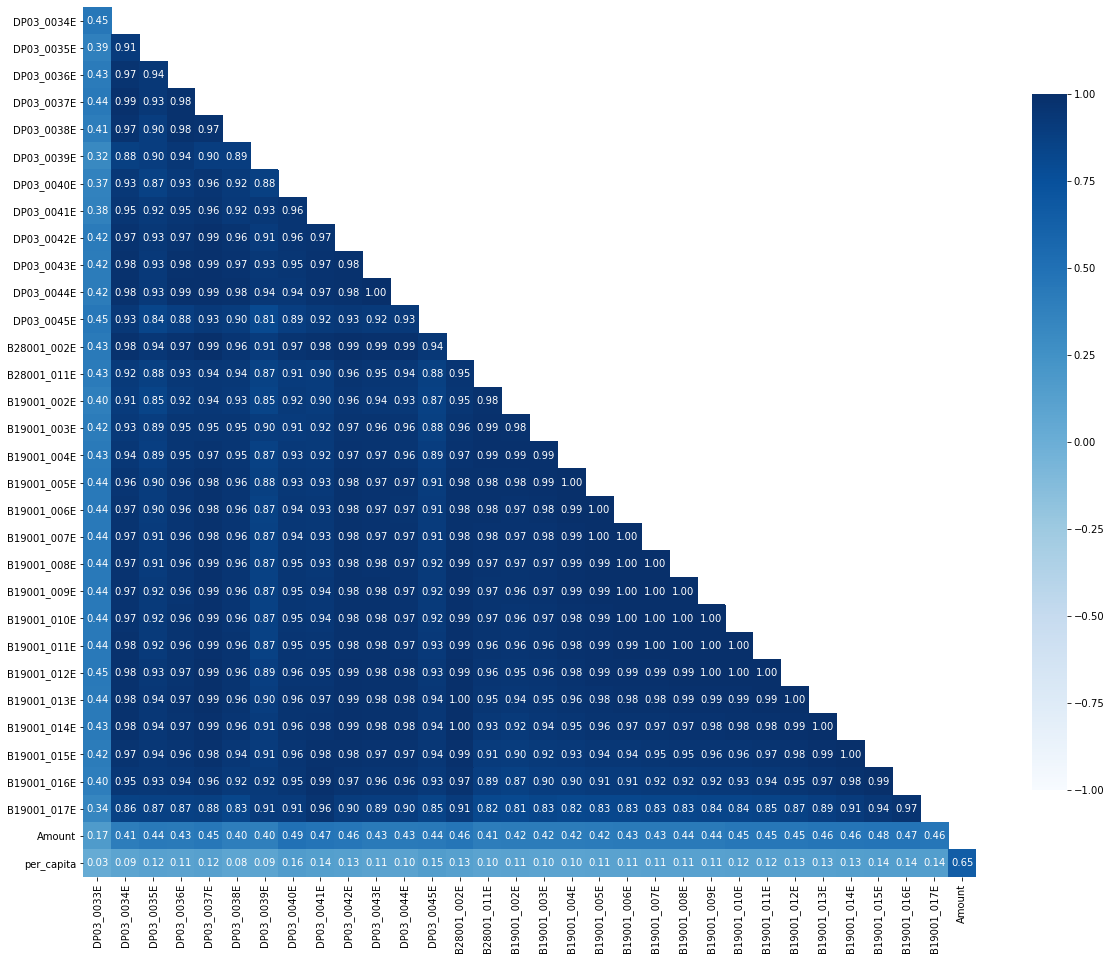

In [35]:
import matplotlib.pyplot as plt
import seaborn as sb
fig, ax = plt.subplots(figsize=(20, 16))
df_corr = df1.corr()
# mask
mask = np.triu(np.ones_like(df_corr, dtype=np.bool))
# adjust mask and df
mask = mask[1:, :-1]
corr = df_corr.iloc[1:,:-1].copy()
# plot heatmap
sb.heatmap(corr, mask=mask, annot=True, fmt=".2f", cmap='Blues',
           vmin=-1, vmax=1, cbar_kws={"shrink": .8})
# yticks
plt.yticks(rotation=0)
plt.show()
#https://towardsdatascience.com/heatmap-basics-with-pythons-seaborn-fb92ea280a6c